# KNN

In [1]:
# on importe les differentes librairies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from scipy import stats

# on importe les différentes librairies surprise de scikit
from surprise import SVD
from surprise import dataset
from surprise import Reader
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity

# on importe notre fonction de tri
from tri_threshold import filter_reviews

# on importe notre bdd
avis = pd.read_csv("BDD/avis.csv", index_col="Unnamed: 0")
avis_norm = pd.read_csv("BDD/avis_norm.csv")

**Pretraitement**

In [2]:
print(avis.info())
print(avis.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 125299 entries, 0 to 176210
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   author          125299 non-null  object
 1   date_published  125299 non-null  object
 2   title_review    125299 non-null  object
 3   note            125299 non-null  int64 
 4   title           125299 non-null  object
 5   url             125299 non-null  object
 6   comment         102460 non-null  object
dtypes: int64(1), object(6)
memory usage: 7.6+ MB
None
                note
count  125299.000000
mean        7.329683
std         2.109915
min         0.000000
25%         6.000000
50%         8.000000
75%         9.000000
max        10.000000


In [3]:
# Suppression des doublons
avis.drop_duplicates(inplace=True)

# Suppression des lignes avec des valeurs manquantes dans 'note'
avis.dropna(subset=['note'], inplace=True)

# Création de avis_clean à partir de avis pour les opérations de nettoyage
avis_clean = avis.copy()

In [4]:
label_encoder = LabelEncoder()
avis_clean['author_encoded'] = label_encoder.fit_transform(avis_clean['author'])
avis_clean['title_encoded'] = label_encoder.fit_transform(avis_clean['title'])

In [5]:
# 1. Filtrage initial avec l'IQR pour 'note'
Q1 = avis_clean['note'].quantile(0.25)
Q3 = avis_clean['note'].quantile(0.75)
IQR = Q3 - Q1

avis_clean = avis_clean[(avis_clean['note'] >= (Q1 - 1.5 * IQR)) & (avis_clean['note'] <= (Q3 + 1.5 * IQR))]

# Assurez-vous de réinitialiser l'index après le filtrage pour aligner les données
avis_clean.reset_index(drop=True, inplace=True)

# 2. Calcul et filtrage supplémentaire avec le score Z pour 'note'
# Recalcul des scores Z directement sur le DataFrame filtré par IQR
z_scores = np.abs(stats.zscore(avis_clean['note']))

avis_clean = avis_clean[z_scores < 3]

# Réinitialisation de l'index une fois de plus si nécessaire
avis_clean.reset_index(drop=True, inplace=True)

print(f"Nombre d'avis après filtrage IQR et score Z: {len(avis_clean)}")

Nombre d'avis après filtrage IQR et score Z: 124400


In [6]:
# Sélection des caractéristiques à normaliser, y compris les encodées
features = ['author_encoded', 'title_encoded', 'note']

# Conversion du DataFrame pandas en une matrice dense numpy avant le scaling
data_dense = avis_clean[features].to_numpy()

# Initialisation et application du StandardScaler
scaler = StandardScaler()
avis_normalized = scaler.fit_transform(data_dense)

# Conversion des données normalisées en DataFrame pour une manipulation ultérieure
avis_normalized_df = pd.DataFrame(avis_normalized, columns=features)

# Vérification finale du nombre d'avis
print(f"Nombre final d'avis prêts pour le KNN après prétraitement : {avis_normalized_df.shape[0]}")


Nombre final d'avis prêts pour le KNN après prétraitement : 124400


In [7]:
# Sélection des lignes où la note est égale à 0
jeux_avec_note_zero = avis_normalized_df.loc[avis_normalized_df['note'] == 0]

# Affichage des résultats
print(jeux_avec_note_zero)

Empty DataFrame
Columns: [author_encoded, title_encoded, note]
Index: []


In [8]:
num_users = avis_clean['author'].nunique()
num_items = avis_clean['title'].nunique()

print(f"Il y a {num_users} auteurs et {num_items} jeux")

# Calcul de la sparsité
sparsity = (len(avis_clean) / (num_users * num_items)) * 100
print(f"Notre matrice a une sparsité de {sparsity:.2f}% ")


Il y a 2564 auteurs et 3057 jeux
Notre matrice a une sparsité de 1.59% 


In [9]:
# Mapping des identifiants encodés à des indices allant de 0 à n-1
user_ids = avis_clean['author_encoded'].astype('category').cat.codes
item_ids = avis_clean['title_encoded'].astype('category').cat.codes

# Création de la matrice creuse
rows, cols = user_ids.values, item_ids.values
ratings = avis_clean['note'].values

# Important : ajustement des dimensions pour correspondre au nombre d'auteurs et de jeux uniques
matrice_sparse = csr_matrix((ratings, (rows, cols)), shape=(num_users, num_items))

print(matrice_sparse)



  (0, 24)	8
  (0, 25)	7
  (0, 37)	10
  (0, 163)	10
  (0, 164)	10
  (0, 1066)	10
  (0, 1090)	6
  (0, 1216)	8
  (0, 1340)	8
  (0, 1385)	8
  (0, 1712)	8
  (0, 1919)	8
  (0, 2043)	10
  (0, 2584)	10
  (0, 2609)	7
  (1, 16)	5
  (1, 20)	8
  (1, 30)	8
  (1, 49)	7
  (1, 50)	7
  (1, 53)	6
  (1, 76)	4
  (1, 107)	9
  (1, 133)	9
  (1, 166)	7
  :	:
  (2563, 2195)	7
  (2563, 2212)	8
  (2563, 2224)	4
  (2563, 2241)	9
  (2563, 2259)	8
  (2563, 2290)	6
  (2563, 2359)	8
  (2563, 2360)	8
  (2563, 2374)	6
  (2563, 2411)	10
  (2563, 2503)	7
  (2563, 2535)	2
  (2563, 2606)	9
  (2563, 2691)	10
  (2563, 2709)	10
  (2563, 2755)	7
  (2563, 2774)	6
  (2563, 2790)	9
  (2563, 2813)	5
  (2563, 2849)	4
  (2563, 2875)	10
  (2563, 2915)	8
  (2563, 2960)	9
  (2563, 3051)	6
  (2563, 3053)	10


In [10]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import numpy as np

# Supposons que matrice_sparse est votre matrice CSR de sparsité
# Convertir la matrice sparse en une matrice dense pour le calcul des distances
matrice_dense = matrice_sparse.toarray()

# Calculer la matrice de similarité euclidienne
similarite_euclidienne = euclidean_distances(matrice_dense)

# Calculer la matrice de similarité cosinus
similarite_cosinus = cosine_similarity(matrice_dense)


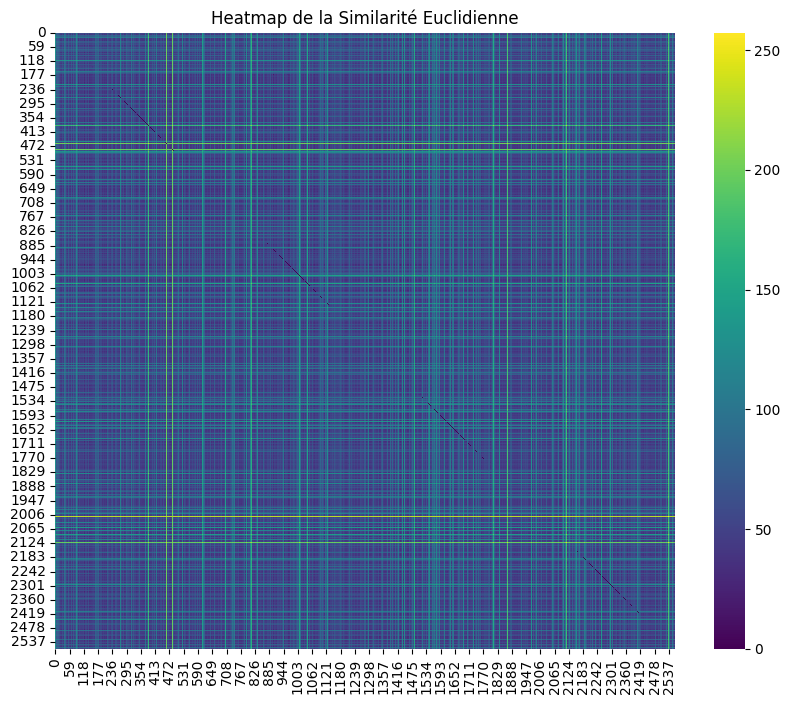

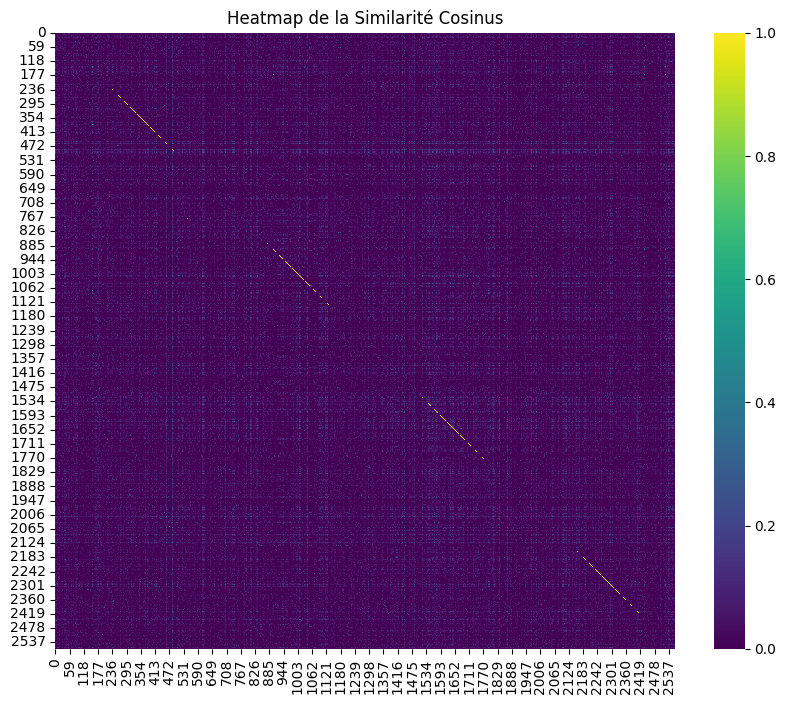

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualisation de la similarité euclidienne
plt.figure(figsize=(10, 8))
sns.heatmap(similarite_euclidienne, cmap='viridis')
plt.title('Heatmap de la Similarité Euclidienne')
plt.show()

# Visualisation de la similarité cosinus
plt.figure(figsize=(10, 8))
sns.heatmap(similarite_cosinus, cmap='viridis')
plt.title('Heatmap de la Similarité Cosinus')
plt.show()


In [ ]:
# Préparation des caractéristiques et de la cible
X = avis_clean[['author_encoded', 'title_encoded']]  # ou vos colonnes de caractéristiques
y = avis_clean['note']

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Création et entraînement du modèle KNN
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(X_train, y_train)

In [ ]:
# Faire des prédictions sur l'ensemble de test
y_pred = knn.predict(X_test)

# Calcul du RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

# Calcul du MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")


In [ ]:
print(avis.describe())

In [ ]:
print(avis_clean.describe())

In [ ]:
# Filtrer avis_clean pour inclure uniquement les lignes avec des notes >= 5
avis_filtré = avis_clean[avis_clean['note'] >= 5]

In [ ]:
# Préparation des caractéristiques et de la cible avec les données filtrées
X_filtré = avis_filtré[['author_encoded', 'title_encoded']]
y_filtré = avis_filtré['note']

# Division des données filtrées en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_filtré, y_filtré, test_size=0.2, random_state=42)

In [ ]:
# Création et entraînement du modèle KNN sur les données filtrées
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = knn.predict(X_test)

# Calcul du MAE sur les données filtrées
mae_filtré = mean_absolute_error(y_test, y_pred)
print(f"MAE sur les avis avec des notes >= 4: {mae_filtré}")

# SVD

In [ ]:
algo = SVD(n_factors=50,n_epochs=20,lr_all=0.005,reg_all=0.05)

reader = Reader(line_format='user item rating', rating_scale=(0,10))

class MyDataset(dataset.DatasetAutoFolds):
    def __init__(self, df, reader):
        self.raw_ratings = [(uid, iid, r, None) for (uid, iid, r) in
                            zip(df['author'], df['title'], df['note'])]
        self.reader = reader


data_test = MyDataset(avis_filtré, reader)
cross_validate(algo, data_test, measures=['RMSE', 'MAE'], cv=5, verbose=True)